# Automation of Microfluidic Experiments -- 
## 2 Pump Control

Welcome to this short explantion of the various features of the 2pump_control.py software
This code was written to control a 2 input microfluidic mixer. 

The main idea behind the project was to make a 4 input microfluidic chip, that would be able to take 2 chemicals, and dilute each one independently, and search for various interesting chemical features at different concentrations and stoichometries of chemicals. 

This code is a precursor to that code, that is titled 4pump_control ... 

It is simpler, and was written to interface with a 2 input chip with 2 independent syringe pumps. The functions written were made to dilute a given chemical, and then measure intensity of the mixture (either fluorescent, or just how transmitance). 

First of all, let us load the .py file 

In [21]:
%run 2pump_control.py

Initially, we have to create a dictionary of available pumps. We will make this dictionary with the pump_tester() function. It can take baudrate as a optional parameter.

It iterates through all detected COM ports, assumes a pump is connected and cycles the pump on and off. It then asks the user if a pump is connected. If yes, the user is meant to press enter, if not, any other input is acceptable. 

If a pump is connected, and enter is pressed, the function then asks for a pump number. The pumps should be numbered "1" and "2", with pump "1" containing the chemical, and pump "2" containing the dilution agent.

### Pump compatibility
This project used Chemyx Inc. Fusion 100 & 300 syringe pumps, which connect via serial over USB. Chemyx Inc. provides a basic interface which is loaded by the 2pump_control.py file. This interface is the file connect.py.

If a different set of pumps were to be used, if the producer produced a different python control program, the connect.py file could be feasibly simply replaced, with a few adjustments to the Pump class. 

Otherwise, if the control has to be implemented directly, it can be implemented into the Pump class. Once the Pump class is adjusted, the rest of the program should function without any other edits.

In [22]:
# does not work with bluetooth turned on... gets stuck on bluetooth COM ports
pump_dictionary = pump_tester()

available COM ports are: []


There are also dotstrings for all the functions and methods within the 2pump_control.py program. So if anything is unfamilar, you can type in:


    help(__function__)


    help(pump_tester)

In [23]:
help(pump_tester)

Help on function pump_tester in module __main__:

pump_tester(baudrate=38400)
    Summary:
        uses connect.py from pump manufacturer website to check for open serial ports
        and then generate and return a list of pumps and ports
        
        need to define pumps with numbers 1, 2: pump 1 has the chemical of interest, 
        pump 2 contains the dilution agent
        
        DOES NOT WORK ON WINDOWS IF BLUETOOTH TURNED ON
        (gets stuck on bluetooth COM ports)
    Optional Parameters:
        baudrate (int): baudrate used for communication with Chemyx Fusion Pumps



Once the pump dictionary is created, we can move on to the main section of the program.
# The Experiment class

In [24]:
help(experiment)

Help on class experiment in module __main__:

class experiment(builtins.object)
 |  experiment(pump_dic, pump1_max_vol, pump2_max_vol, overall_flow, equilibration_time, target_value, path123, units, syringe_diameter, syringe_volume, _pumps, communication_rate=38400, colour='R', load_dic_path=0)
 |  
 |  DESCRIPTION
 |      Main working class of the program... is responsible for file structure generation, loading a dictionary
 |      of available pumps and initializing them internally as Pump objects, based on the class above
 |      also requires the fill volume of syringes to auto stop any experiments before fluid is exhausted
 |      was imagined to be able to run multiple experiments, however, due to how the files are saved
 |      it makes more sense to "end" the class (closes the open serial connections to the pumps)
 |      and create a new iteration of the experiment class for new experiments or new trials
 |  
 |  ARGUMENTS:
 |      pump_dic (dic): pump dictionary generated by 

The experiment class contains all the functions of the program. You can see the input parameters below. Most should be fairly intuitive. The pump max volume refers to the volume of fluid inside the pumps, with the syringe_volume refering to the actual maximum volume the syringe pump could contain. 
The overall_flow is the overall flow rate of the two pumps combined. It remains constant throughout the experiment. 


In [ ]:
pump_dictionary # defined earlier
pump1_max_volume = 10 #in mL
pump2_max_volume = 10
overall_flow = 0.8  #in units set below
equilibration_time = 20  #in seconds
target_sensor_readout = 100  #explained later
path123 = os.path.dirname(os.path.abspath("2pump_control.py")) #any path could be used as input
units = "mL/min" #other option is μL/min
syringe_diameter = 15.68 #in mm
syringe_volume = 12  #in mL
_pumps = "OFF"  #should be "OFF" if pumps are not connected, but many features will not work

# Optional Arguments
communication_rate = 38400  # baudrate to be used
colour = "R"  # colour channel to be used by the target_finding and peak_finding methods
load_dic_path = 0  # explained later


exp = experiment(pump_dictionary, pump1_max_volume, pump2_max_volume, overall_flow, 
                 equilibration_time, target_sensor_readout, path123, units, 
                 syringe_diameter, syringe_volume, _pumps,
                 communication_rate, colour, load_dic_path)

Once the class is initialized, it will create a series of folders in the path of path123. It also makes a .pkl file, whose use will be demonstrated later.

## Methods of the Experiment class
All the different features of the 2pump_control software are implemented as methods of the experiment class. You can see them in the following way:

In [ ]:
method_list = [method for method in dir(experiment) if method.startswith('__') is False]
print(method_list)

You can see, there are a number of methods, but not all of them are equally useful...

Let us start with the assumptions the program makes about the experimental setup. It is assumed that measurements will be taken using a Ximea Camera, through the Ximea CamTool GUI program. Ximea CamTool can be found on the Ximea website, as well as a version of it is included in this github repo. 

https://www.ximea.com/support/wiki/allprod/XIMEA_CamTool

The 2pump_control.py software records data by taking over control of the mouse and keyboard. It saves images using the CamTool, but those are meant only for reference. All the data processing is done by also taking a line profile, and using its average as an intensity reading. The way it is set up, it assumes it is working on a 4K screen on Windows, with Ximea CamTool maximized on the screen.

![CAMTOOL](XimeaCamTool.png)

The line profile in the lower section of the screen has to be there. It can be enabled in CamTool with:

Tools -> Line Profile. 

The line profile has to be lined up over the region of interest. In the project, a line width averaging of 251 pixels was used. The program assumes it is working with a black and white camera. If a colour camera is used, the colour channel to be used has to be defined in the experiment class. See the dotstring for more details.
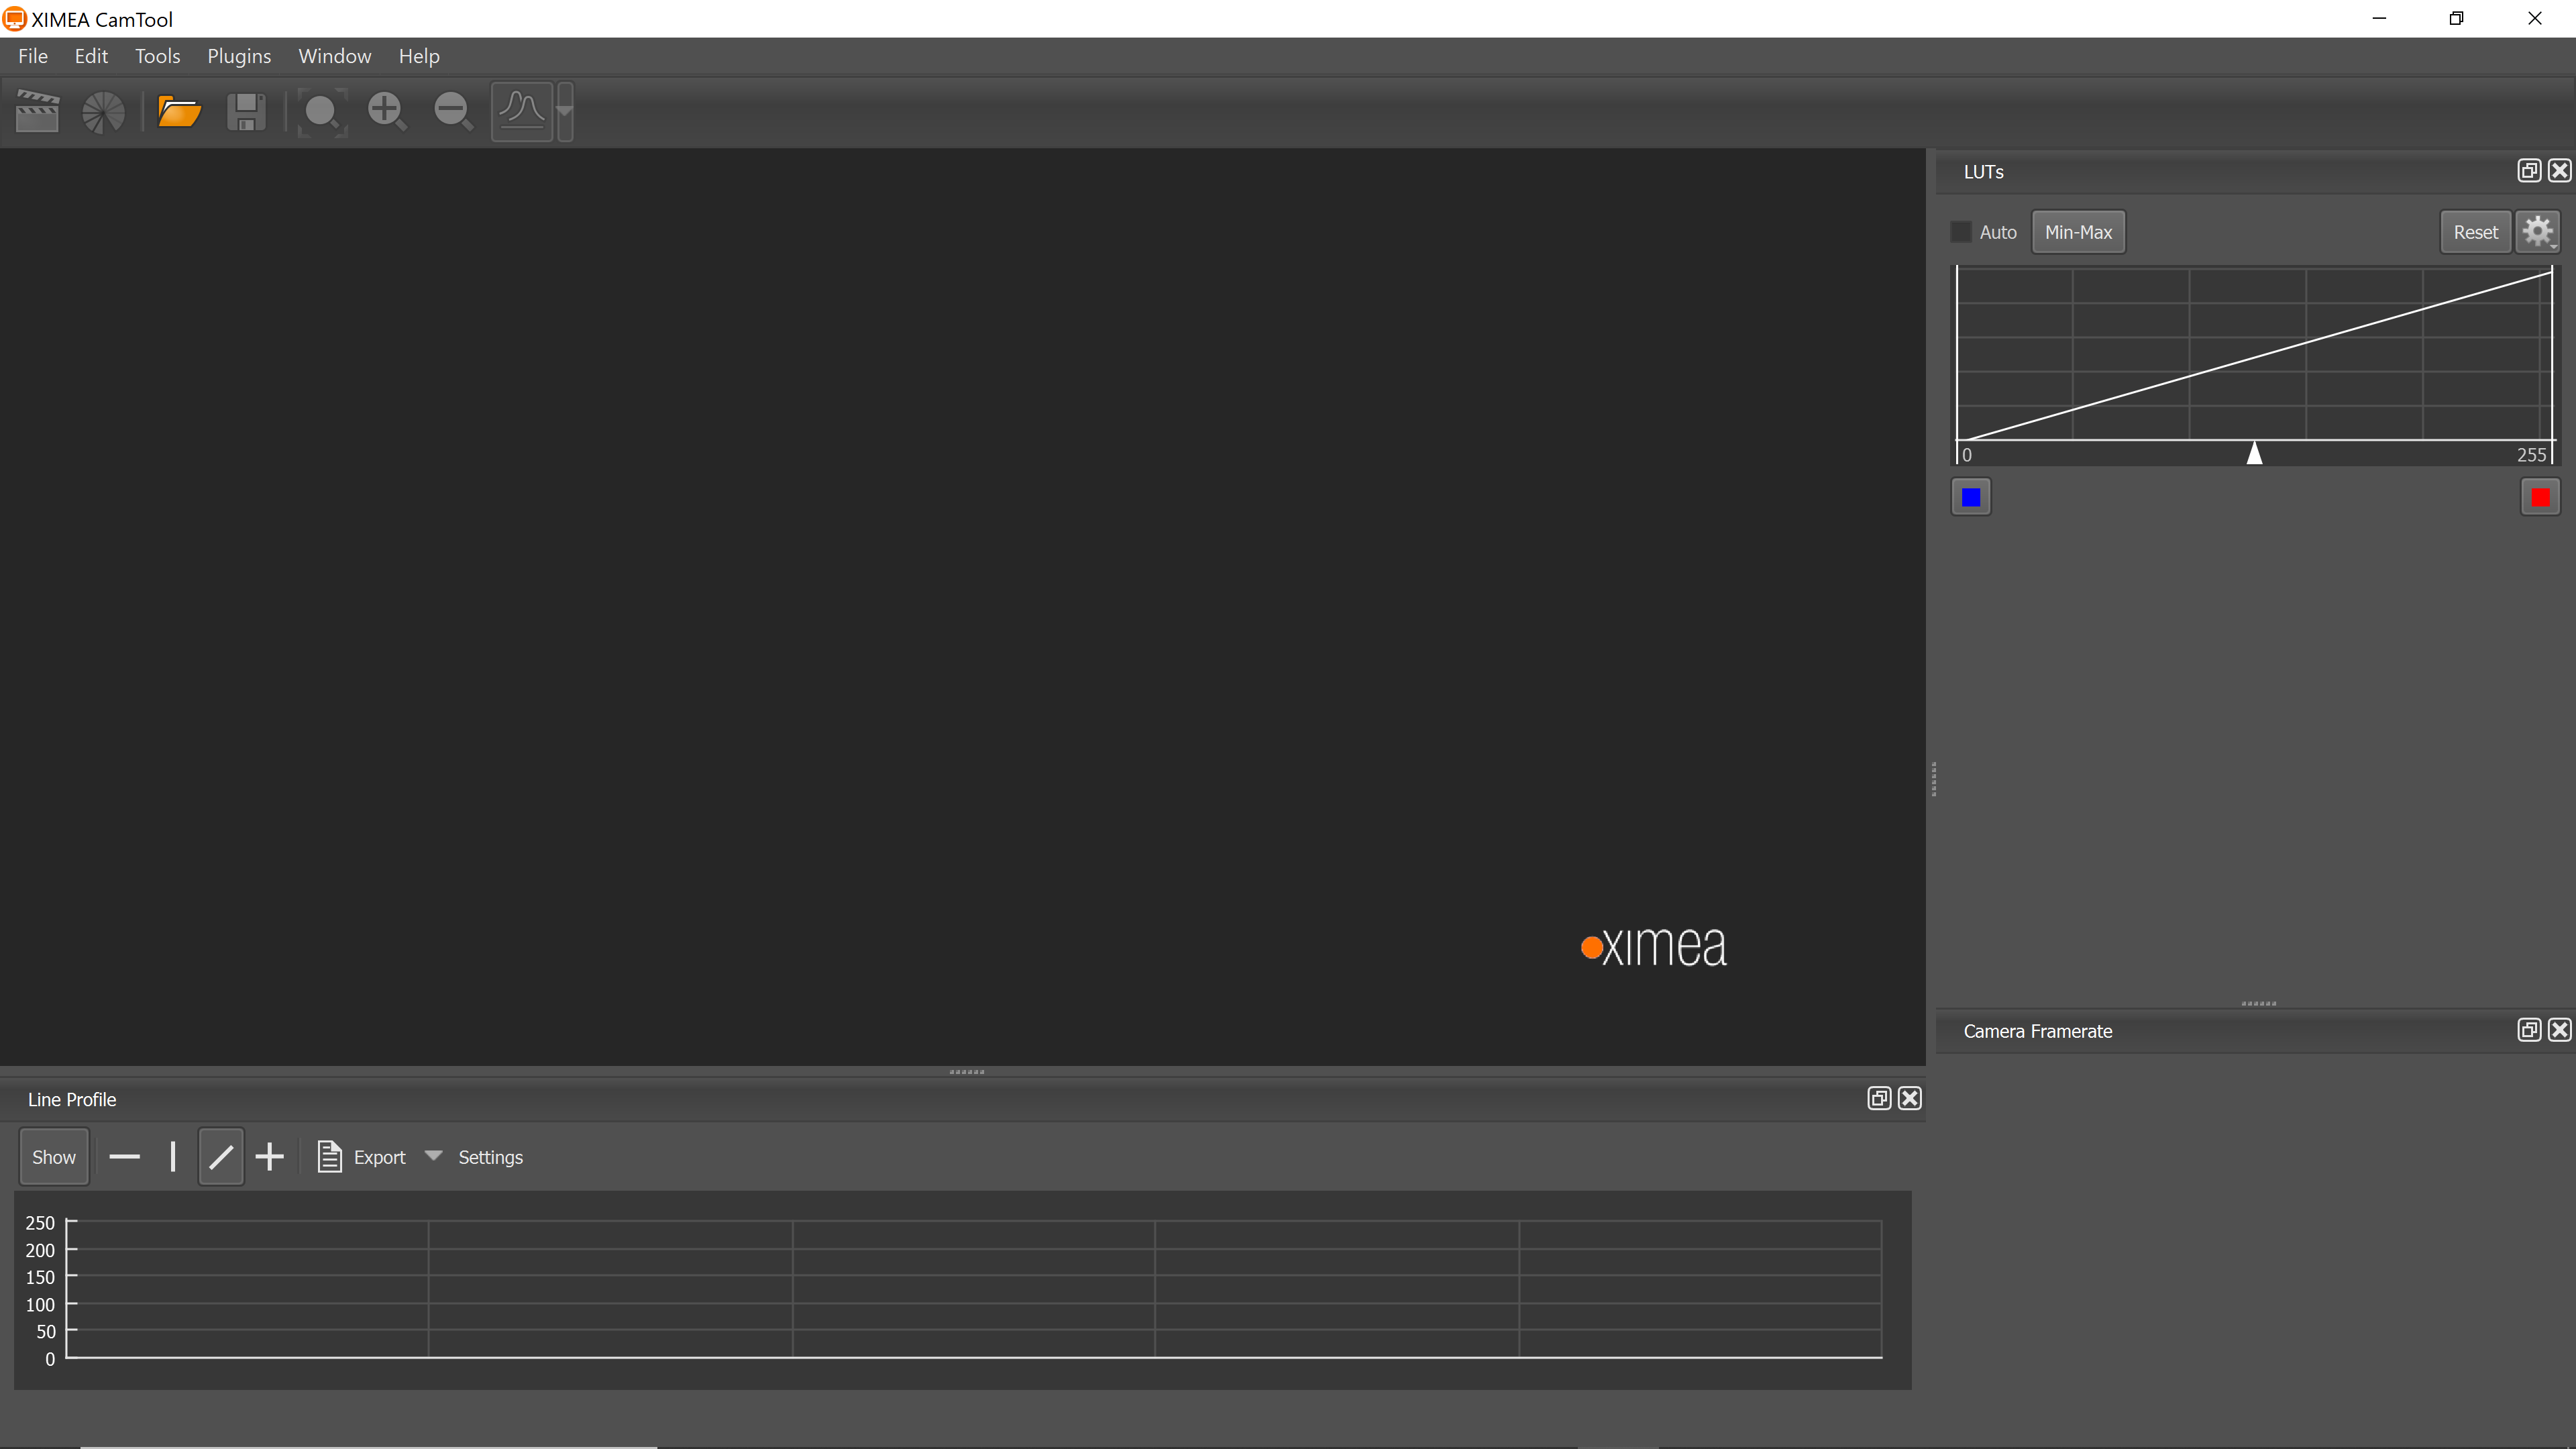

## Operating the 2pump_control program


The first thing to do intially, before any measurements are done: the steady state equilibration time for the set up neets to be found. That is, the time it takes from the pumps chaning their relative pumping speeds to that change being visible in the measurement area of the setup, including the time it takes for that changed flow to stablize. 

For this, the steady_state_time_finder method was written, that starts with pump 1 pumping at half power, i.e. with half the flow rate of the overall flow rate, and then once enter is pressed, it increases to 3/4 power. Then, enter has to be pressed again once the flow has stabilized.

In [ ]:
print(help(exp.steady_state_time_finder()))
exp.steady_state_time_finder()

Once you know this steady state time for a particular set up, you can just define it in the intialization of the class. You can also use the optional parameters to vary the initial pump power of pump 1, and by how much it increases after pressing enter.

## A note on pump power

In this work, pump power is refered to many times. It is simply a parameter, that goes from 0 to 1, with 0 corresponding to the pump stopped, and 1, corresponding to the pump pumping at the overall flow rate defined at the class initialization. Because the overall flow is constant, pump 1 power + pump 2 power = 1. So if pump 1 is set to 0 power, then pump 2 should not pump and vice versus. However, due to how the pumps handle an input rate of 0, and because it was not necessary for the project, the code currently does not function correctly when 0 or 1 is inputted as a pump power. Therefore, if manually defining pump power, it should be >0 and <1.

# Cycling through different concentrations
As briefly mentioned at the beginning, the program was written to investigate different concentrations of a given chemical. The main way that this is done is through the use of "maps". A map is simply a series of sensor measurements (via the Ximea CamTool line profile) corresponding to different flow rate ratios (FRRs) of the pumps. To generate a map, first you have to aim Ximea CamTool to the correct save location:

    exp.aim_ximea(exp.path_fold_map))

Once you run this cell, you have 2 seconds to alt tab to the maximized Ximea CamTool window. The exp.path_fold_map attribute is simply the path to the folder the class initialization made to store the save files from generating the map. The other 2 folder locations will be explained later.

In [ ]:
exp.aim_ximea(exp.path_fold_map))

You will need to aim the Ximea CamTool before any map you make. But you will not need to do it with the automatic functions. 

Once Ximea is "aimed", and the syringe pumps are loaded with filled syringes etc., the concentration space can be mapped. Again, after running the cell, you have to switch to the maximized Ximea CamTool window for the duration of the experiment.

In [ ]:
bounds = (0.01, 0.99) ## corresponds to the maximum and minimum pump 1 power that will be measured

n_samples = 10 ## number of sample points to be take in the map

reverse_flag = True ## if true, will start with high pump 1 power, if False, will start with low pump 1 power

                               ## if true, will beep after measurement, and keep the pumps running at same rate
sample_collection_flag = False ## for another equilibration length of time, so that samples of the output fluid
                               ## can be collected
        
exp.map_the_space(bounds, n_samples, reverse_flag, sample_collection_flag)

The pump 1 powers and various other parameters are saved in a .txt file called map *time*. It has a header labelling the data columns. 

## Note on pump performance
With the Chemyx Inc Fusion pumps, it was found that at large FRRs, (e.g. pump power > 0.9 or <0.1), the high pumping pump can overwhelm the other pump, and cause no output of one of the pumps. This does not occur when the pump power is reduced gradually. The reverse flag was used to do this semi manually, for example by setting the bounds as (0.1, 0.001) and then having the reverse_flag as True. This kind of splitting up the maps is done automatically in the 4pump_control.py program. 

In the map above, the spacing between the sample points is linear in the "pump power" space, i.e. the is a linear spacing of tested concentrations, that correspond to the (pump 1 power)*(syringe concentration).

If you would want to enter your own spacing for the points, you can do that using the following function:
    
    exp.map_the_space_input_FRR_array(FRR_array, reverse_flag, sample_collection_flag)

In [ ]:
FRR_array = [10, 25, 50, 75, 100] ## the FRRs (pump 1 power / pump 2 power) that will be test

reverse_flag = True ## if true, the reciprocal FRRs will be used for the map 
                    ## i.e. the actual FRRs tested will be 1/10, 1/25, 1/50, 1/75, 1/100

                               ## if true, will beep after measurement, and keep the pumps running at same rate
sample_collection_flag = False ## for another equilibration length of time, so that samples of the output fluid
                               ## can be collected

exp.map_the_space_input_FRR_array(FRR_array, reverse_flag, sample_collection_flag)

# Data Analysis

After a map is created, you can use the same class to load the map:
       
       colour = "R"  #colour channel to be used... see note below
       pump1_power, flow_ratios, intensity = exp.load_the_map(colour)
       
Note: The colour channel to be used depends on two things. If the camera is black and white, because of how the line profile txt file is formatted, you have to set the colour to the "R", red, channel. If it is a colour camera, you can set it to "R", "G", "B", "BW", "RIN", "BIN", "GIN", "BWIN" for red, green, blue, black and white, red inverse, blue inverse, green inverse and black and white inverse respectively. The inverse colours are simply "255 - sensor readout". The BW mode for a colour camera combines the RGB values and averages them and gives that as an intensity value. 



In [ ]:
colour = "R"
pump1_power, flow_ratios, intensity = exp.load_the_map(colour)

You can also quickly plot the map, with minimal data analysis but also with great ease of use, if you want to quickly look at the data after collection.

In [ ]:
colour = "R"
exp.plot_map(colour)

You can also perform a linear fit of the current loaded map. This will be saved within the class and used by later functions. It was found that linear fits are generally poor approximations of real world systems, but the function was created beforehand. The linear fitting also returns the fitting parameters, apart from saving them internally.
    
    colour = "R"
    slope, intercept, r_value, std_err = exp.linear_fit_of_map(colour)

In [ ]:
colour = "R"
slope, intercept, r_value, std_err = exp.linear_fit_of_map(colour)

Based on this linear fit, the following function can give you a prediction of what pump 1 power would be needed for a particular sensor readout.

In [ ]:
target_sensor_readout = 100
estimated_pump1_power = exp.estimate_needed_pump1_power(target_sensor_readout)

### Target sensor readout -- Basic Implementation
The program can even run the pumps and perform a readout of that estimated pump power. I.e. once it maps the space, and generates a linear fit, it can then make a prediction what pump power is needed to reach the target sensor readout set in the class initialization, run that pump power, and read out the sensor, and state if the prediction worked or not. 

In [ ]:
exp.test_estimated_reading()

This function will also guide the Ximea CamTool program to save in the testingmap folder. That is what it was created for.

The test_estimated_reading will default to the initially defined target_sensor_readout and to the "R" colour channel (i.e. B&W camera set up), but it can be passed any target value and colour channel to read on the sensor. Note that it will still use the linear fit based on the colour channel that was initially used to make the linear fit, i.e. changing the colour channel here does not change the colour channel used for the whole process, only for this sensor readout. 

In [ ]:
target = 175
colour = "G"

exp.test_estimated_reading(target, colour)

The test_estimated_reading method saves a .txt file with the name

Estimated pump1 power "iteration number".txt

# Target Finding function -- Advanced Implementation
The above described implementation of a way of estimating a needed pump 1 power for a desired sensor readout is limitted to scenarios that are close to a linear fit and it does not take any feedback. If the sensor readout is far from the target value, the program does not try to iterate on its guess. Let us fix this. A quadratic fitting function, minimize_scalar, from scipy.optimize, has been implemented to iterate over various sensor readouts, creating a feedback loop that then guides the program towards the target value.

In [ ]:
mybounds = (0.001, 0.999) # bounds of possible pump 1 power in the search of the target value
x_atol = (0.02) # absolute tolerance of pump power in search of target value
maxiter = 7 # maximum number of iterations allowed in search


exp.target_finding_function(mybounds, x_atol, maxiter)

The above parameters are the default values of those parameters, i.e. if you wanted to run those parameters, you could just enter the code:

    exp.target_finding_function()
The bounds are limitted by the definition of pump power, i.e. >0 and <1, but very small numbers such as 0.0000001 with overall flow of e.g. 8 mL / min, are also misinterpreted by the Chemyx Inc. Fusion pumps. 

The data is saved in the auto_fit folder. At the end, a .txt file is created with the pump 1 power and the sensor readouts. It has the name:

    target fitting dataset itr *iteration number*.txt
### Changing internal attributes
If you wish to change the taget value attribute in an existing instances of the experiment class, you can do this with:

    exp.target_value = 25
You can do this with any of the attributes defined in the class. So you could also do it for e.g.
    
    exp.pump1_max_vol = 10

# Peak finding function -- Advanced Implementation
This is an alternative inplementation of the Target seeking function, which uses the same technique, and same algorithm base, but is modified so that it will maximise the sensor readout. This can be used for maps where there is e.g. a gaussian shape. 

The saved files are in the same location as with the target finding function, and you can pass in the same inputs as well.

In [ ]:
mybounds = (0.001, 0.999) # bounds of possible pump 1 power in the search of the target value
x_atol = (0.02) # absolute tolerance of pump power in search of target value
maxiter = 7 # maximum number of iterations allowed in search


exp.peak_finding_function(mybounds, x_atol, maxiter)

# Ending the program
After map is created, or a particular experiment is concluded, the program has to be "closed". This simply corresponds to a closing of the open COM ports to the syringe pumps so that a new instance of the experiment class can be created. This is done with the command:
    
    exp.end()


In [ ]:
exp.end()

# Post Experiment Data Loading

As previously mentioned, once an experiment is complete, but the "experiment" class instance is still running, the program is able to load the data from the file structure it created. No additional implementation to navigate the files created is necessary. The program can also do this once the instance is gone i.e. the program can load data at any time, not only while the files are created. To do this, you need another instance of the experiment class, and you simply point it to the .pkl file of the experiment files you wish to load, with the load_dic_path argument. This argument should be the path to said "path_config" pickle file. 


In [ ]:
pump_dictionary # defined earlier
pump1_max_volume = 10 #in mL
pump2_max_volume = 10
overall_flow = 0.8  #in units set below
equilibration_time = 20  #in seconds
target_sensor_readout = 100  
path123 = os.path.dirname(os.path.abspath("2pump_control.py")) #any path could be used as input
units = "mL/min" #other option is μL/min
syringe_diameter = 15.68 #in mm
syringe_volume = 12  #in mL

_pumps = "OFF"

communication_rate = 38400  # baudrate to be used
colour = "R"  # colour channel to be used by the program

   #example path to pickle file
load_dic_path = "C:\\Users\\Ignacy\\OneDrive - Imperial College London\\MSci\\Data\\Term 2\\Mixer V27\\Simple Pumpkin Experiment 2022-02-21\\path_config 15.57.pkl"

exp_data_loading = experiment(pump_dictionary, pump1_max_volume, pump2_max_volume, overall_flow, 
                 equilibration_time, target_sensor_readout, path123, units, 
                 syringe_diameter, syringe_volume, _pumps,
                 communication_rate, colour, load_dic_path)

After this, the load_the_map(colour) method should work as before. You can also give the program a path config pickle file to load a previously made map, and to use the linear_fit_of_map(colour) method, and then use the test_estimated_reading method based on the already collected map. This feature becomes more important in the 4pump_control.py program.

In [ ]:
pump1_power, flow_ratios, intensity = exp_data_loading.load_the_map(colour)

Code developed by
    
    Ignacy Bartnik
    IgnacyABartnik@gmail.com
Supervised by

    Robert Strutt
    Nick Brooks
Created as part of
    
    Master Project
    MSci Chemistry with Molecular Physics
    Imperial College London